---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Prabu Jeyabalan
    affiliations:
      - id: U79959218
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-04-05"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [1]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# df.printSchema() # comment this line when rendering the submission
# df.show(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/09 15:15:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [2]:
#| eval: true
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop rows where required columns are null
df = df.dropna(subset=[
    'MIN_YEARS_EXPERIENCE', 
    'MIN_EDULEVELS', 
    'LOT_V6_SPECIALIZED_OCCUPATION_NAME', 
    'SALARY'
])

# Define categorical variable
categorical_cols = ['LOT_V6_SPECIALIZED_OCCUPATION_NAME']

df = df.filter(df["MIN_EDULEVELS"] != 99)

# Compute percentiles
quantiles = df.approxQuantile("SALARY", [0.01, 0.99], 0.0)
lower_bound, upper_bound = quantiles

# Filter to keep only data within bounds
df = df.filter((df["SALARY"] >= lower_bound) & (df["SALARY"] <= upper_bound))



# StringIndexer and OneHotEncoder for categorical variable
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# VectorAssembler for features
assembler = VectorAssembler(
    inputCols=['MIN_YEARS_EXPERIENCE', 'MIN_EDULEVELS'] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Create and apply pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = pipeline.fit(df).transform(df)

# Show sample of transformed dataset
data.select('features', 'SALARY').show(5, False)


+---------------------------+------+
|features                   |SALARY|
+---------------------------+------+
|(12,[0,1,2],[2.0,2.0,1.0]) |92962 |
|(12,[0,2],[10.0,1.0])      |107645|
|(12,[0,1,5],[6.0,2.0,1.0]) |192800|
|(12,[0,1,5],[12.0,1.0,1.0])|125900|
|(12,[0,1,5],[6.0,2.0,1.0]) |192800|
+---------------------------+------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [16]:
#| eval: true
#| echo: true
train_data, test_data = data.randomSplit([0.8, 0.2], seed=777)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(15745, 134)


(4019, 134)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [17]:
#| eval: false
#| echo: false
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression

# Train the linear regression model
lr = LinearRegression(featuresCol='features', labelCol='SALARY')
lr_model = lr.fit(train_data)

# model summary
summary = lr_model.summary

# Coefficients and Intercept
# print("Intercept: {:.4f}".format(glr_model.intercept))
# print("Coefficients:")
# for i, coef in enumerate(glr_model.coefficients):
#     print(f"  Feature {i + 1}: {coef:.4f}") 

# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T Values:", [f"{val:.4f}" for val in summary.tValues])
print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
# print(f"Null Deviance: {summary.nullDeviance:.4f}")
# print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
# print(f"Deviance: {summary.deviance:.4f}")
# print(f"Residual DF: {summary.residualDegreeOfFreedom}")
# print(f"AIC: {summary.aic:.4f}")

# 1. Pull feature names directly from Java backend
# feature_names = summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

print("---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals)) 

25/04/09 15:55:09 WARN Instrumentation: [ad768bcc] regParam is zero, which might cause numerical instability and overfitting.



--- Regression Summary ---
Coefficient Standard Errors: ['82.7579', '416.4888', '5021.0075', '5058.9374', '5065.6604', '5062.0326', '5062.8217', '5096.9337', '5118.1055', '5390.6087', '6111.7597', '7351.2224', '5096.4015']
T Values: ['64.4368', '44.7807', '1.9889', '6.7277', '8.1052', '4.1305', '4.9425', '2.3804', '1.7939', '1.9406', '0.5319', '0.3638', '7.4319']
P Values: ['0.0000', '0.0000', '0.0467', '0.0000', '0.0000', '0.0000', '0.0000', '0.0173', '0.0728', '0.0523', '0.5948', '0.7160', '0.0000']
---This is Diagnostic check, No need to print it in the final doc---
Length of features: 4
Length of coefs: 13
Length of se: 13
Length of tvals: 13
Length of pvals: 13


## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [18]:
#| eval: true
#| echo: true
from pyspark.ml.regression import LinearRegression
from pyspark.sql import Row

# Fit indexer separately to get labels (used in encoder)
indexer_model = StringIndexer(inputCol='LOT_V6_SPECIALIZED_OCCUPATION_NAME',
                              outputCol='LOT_V6_SPECIALIZED_OCCUPATION_NAME_idx',
                              handleInvalid='skip').fit(df)

occupation_labels = indexer_model.labels  # List of category names

# Building expanded occupation feature names (excluding the base class if dropLast=True)
expanded_occupation_features = [f"Occupation={label}" for label in occupation_labels[1:]]

# Reconstruct full feature names in the same order as assembled
feature_names = ['MIN_YEARS_EXPERIENCE', 'MIN_EDULEVELS'] + expanded_occupation_features

# Fit linear regression model
lr = LinearRegression(featuresCol='features', labelCol='SALARY', regParam=0.1)
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Step 5: Extract coefficients and build readable DataFrame
features = ['Intercept'] + feature_names
coefs = [lr_model.intercept] + [float(c) for c in lr_model.coefficients]
se = [None] + [float(s) for s in summary.coefficientStandardErrors]
tvals = [None] + [float(t) for t in summary.tValues]
pvals = [None] + [float(p) for p in summary.pValues]

rows = [Row(
    Feature=f,
    Coefficient=c,
    StdError=s,
    TValue=t,
    PValue=p
) for f, c, s, t, p in zip(features, coefs, se, tvals, pvals)]

coefs_df = spark.createDataFrame(rows)
coefs_df.show(truncate=False)


+-------------------------------------------+------------------+------------------+-------------------+----------------------+
|Feature                                    |Coefficient       |StdError          |TValue             |PValue                |
+-------------------------------------------+------------------+------------------+-------------------+----------------------+
|Intercept                                  |37893.48670772949 |NULL              |NULL               |NULL                  |
|MIN_YEARS_EXPERIENCE                       |5332.642860786048 |82.75774469676493 |64.43678329231349  |0.0                   |
|MIN_EDULEVELS                              |18650.572200723946|416.48816913548865|44.780557007026744 |0.0                   |
|Occupation=Oracle Consultant / Analyst     |9969.003862011441 |5018.947771009703 |1.9862736806296541 |0.047020266743849515  |
|Occupation=Enterprise Architect            |34017.65943276673 |5056.88537706166  |6.726998319375185  |1.791722

*The linear regression model uses salary as the dependent variable and includes predictors such as years of experience, education level, and specialized occupation. The intercept of approximately $37,893 represents the baseline salary for a Data Analyst (the reference category) with zero years of experience and the minimum education level. While this specific scenario may not occur in practice, it anchors the model and allows for meaningful interpretation of the other coefficients. Importantly, the model uses Data Analyst as the base class for comparison across occupational groups.*

*Years of experience and education level both have strong, positive, and statistically significant effects on salary. Each additional year of experience increases predicted salary by about $5,333, and each additional level of education increases it by approximately $18,650, holding other factors constant. These findings align with expectations and underscore the value of experience and advanced education in driving compensation. Their p-values are well below 0.05, indicating high statistical confidence in their effects.*

*The model also highlights significant salary differences across occupations relative to Data Analysts. Roles such as General ERP Analyst/Consultant (+$41K), Enterprise Architect (+$34K), and SAP Analyst/Admin (+$29K) command substantially higher salaries, and these differences are statistically significant. Meanwhile, occupations like Healthcare Analyst and Marketing Analyst show modest increases (+$3.2K and +$2.6K respectively), but their p-values suggest these effects are not statistically significant, and may be due to chance. This variation suggests that certain technical and ERP-related roles are rewarded more highly in the market.*

In [19]:
#| eval: true
#| echo: true
from pyspark.ml.evaluation import RegressionEvaluator

# Predictions on test set
predictions = lr_model.transform(test_data)

# Evaluation metrics
evaluator_r2 = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="mae")

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

# Print evaluation metrics
print("\n--- Model Performance on Test Data ---")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


--- Model Performance on Test Data ---
R²: 0.4136
RMSE: 30385.56
MAE: 23743.16


**R² (R-squared): 0.4136**

*This means that approximately 41.36% of the variance in salaries can be explained by the model using the predictors (experience, education level, and occupation). In practical terms, it indicates a moderate fit — the model captures some of the key patterns, but there’s still room for improvement (perhaps by including additional features or non-linear interactions).*

**RMSE (Root Mean Squared Error): 30,385.56**

*This tells that, on average, the model's predictions deviate from the actual salaries by around $30,385, with larger errors weighted more heavily due to squaring. It provides a general sense of prediction error in the same units as salary, and helps you understand the spread of prediction accuracy.*

**MAE (Mean Absolute Error): 23,743.16**

*This is the average of the absolute errors between predicted and actual salaries. Unlike RMSE, it treats all errors equally and is more robust to outliers. It suggests that on average, your predictions are off by about $23,743, which is a more intuitive measure of average prediction error.*

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


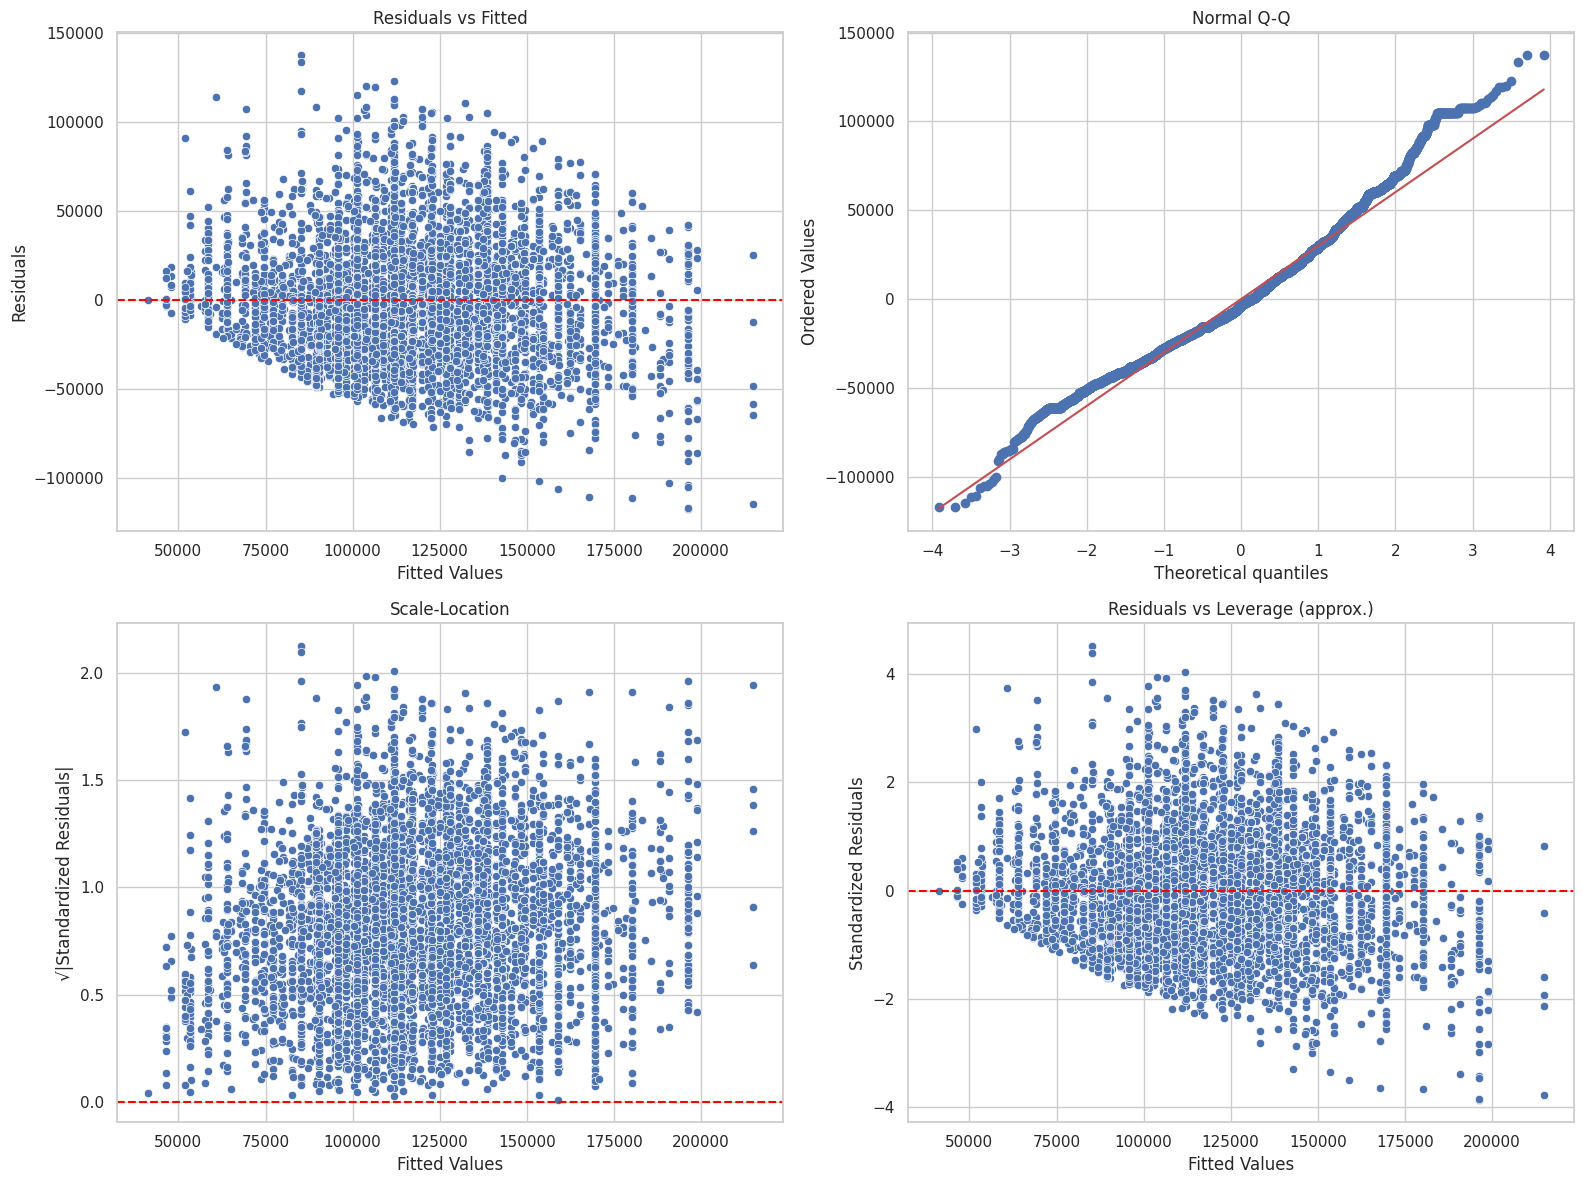

In [20]:
#| eval: true
#| echo: true
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Convert summary predictions to pandas DataFrame
df_pred = summary.predictions.select("SALARY", "prediction").toPandas()

# Compute residuals
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

# Square root of standardized residuals
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Plot diagnostics
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=df_pred)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

# Plot 2: QQ Plot
plt.subplot(2, 2, 2)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# Plot 3: Scale-Location (sqrt std residuals vs fitted)
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=df_pred)
plt.axhline(0, color='red', linestyle='--')
plt.title("Scale-Location")
plt.xlabel("Fitted Values")
plt.ylabel("√|Standardized Residuals|")

# Plot 4: Residuals vs Leverage (approximation using fitted)
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=df_pred)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Leverage (approx.)")
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")

# Save and show
plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


**1.Residuals vs Fitted**

*Shows the residuals (errors) plotted against the model’s predicted salary values.*

- *The funnel shape indicates heteroscedasticity (non-constant variance), where residuals spread wider at higher predicted values.*

- *Ideally, this plot should look like a random cloud — the curved pattern suggests model misspecification or missing variables.*


**2. Normal Q-Q Plot**

*Compares the distribution of residuals to a normal distribution.*

- *Most points fall along the diagonal line, indicating the residuals are roughly normally distributed, but tails deviate.*

- *Deviations at the ends suggest some extreme errors or outliers in the model's predictions.*

**3. Scale-Location Plot**

*This is the Scale-Location plot, which helps assess the assumption of constant variance in residuals — also known as homoscedasticity.*

- *Here, I'm plotting the square root of the standardized residuals against the fitted salary values. Ideally, we want to see a horizontal spread of points without a clear pattern.*

- *In this plot, the residuals appear fairly evenly scattered across the range of predicted salaries, and there's no strong upward or downward trend. This suggests that the variance of the residuals is relatively stable, which supports the assumption of homoscedasticity. So, based on this plot, I don’t see any major concern regarding unequal error variance in the model.*



**4. Residuals vs Leverage**

*Assesses influential data points — those that heavily affect the model.*

- Most points are clustered low and near center, but some outliers on the top-right might have high leverage and influence.

- It is Worth checking individual points for potential outliers or rare combinations of features.

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [21]:
#| eval: true
#| echo: true

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg, count
import numpy as np

# Predictions on test set
pred_glr = lr_model.transform(test_data)

# --- R² using PySpark Evaluator ---
r2_eval = RegressionEvaluator(
    labelCol="SALARY", predictionCol="prediction", metricName="r2"
)
r2 = r2_eval.evaluate(pred_glr)

# --- RMSE using PySpark Evaluator ---
rmse_eval = RegressionEvaluator(
    labelCol="SALARY", predictionCol="prediction", metricName="rmse"
)
rmse = rmse_eval.evaluate(pred_glr)

# --- MAE using PySpark Evaluator (optional) ---
mae_eval = RegressionEvaluator(
    labelCol="SALARY", predictionCol="prediction", metricName="mae"
)
mae = mae_eval.evaluate(pred_glr)

# --- Manually calculate RSS, n, k, BIC (optional) ---
residuals_df = pred_glr.withColumn("residual_sq", pow(col("SALARY") - col("prediction"), 2))
rss = residuals_df.agg({"residual_sq": "sum"}).first()[0]

n = pred_glr.count()  # number of observations
k = len(lr_model.coefficients) + 1  # number of features including intercept

# --- BIC formula: n * log(RSS/n) + k * log(n) ---
bic = n * np.log(rss / n) + k * np.log(n)

# Display evaluation results
print("--- Model Evaluation Metrics ---")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"BIC: {bic:.2f}")


--- Model Evaluation Metrics ---
R²: 0.4136
RMSE: 30385.56
MAE: 23743.16
BIC: 83073.89


- *The R-squared value is 0.4136,the model is able to explain around 41% of the variance in salaries. That’s a reasonably good starting point, especially considering the complexity and noise in salary data.*

- *The RMSE is approximately 30,386, which means that on average, the predicted salaries deviate from the actual salaries by about $30K. Similarly, the MAE is around 23,743, which is a more robust metric showing that the average absolute error is nearly $24K.*

- *Finally, the BIC value is 83,073.89. Since BIC penalizes overly complex models, this value gives us a way to compare this model against others in terms of both fit and simplicity — lower BIC is better.*

*Overall, the metrics show that the model performs moderately well, but there’s still room to improve by exploring non-linear models or including additional predictors.*

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

25/04/09 15:58:03 WARN Instrumentation: [e25f5bb9] regParam is zero, which might cause numerical instability and overfitting.


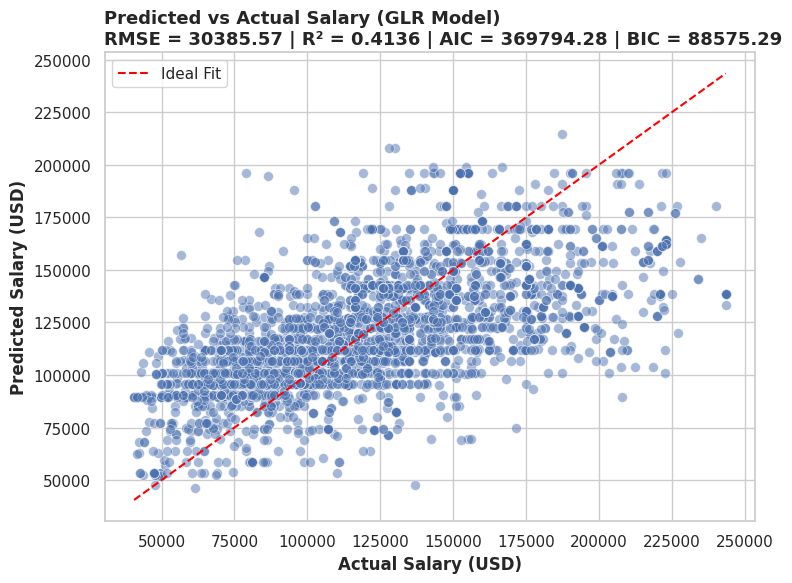

In [22]:
#| eval: true
#| echo: true

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Fit GLR model instead of LinearRegression
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian",
    link="identity"
)
glr_model = glr.fit(train_data)
summary = glr_model.summary

# 2. Predict on test data
pred_glr = glr_model.transform(test_data)

# 3. Convert predictions to Pandas
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# 4. Evaluation Metrics
# R²
r2_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# RMSE
rmse_eval = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction", metricName="rmse")
rmse = rmse_eval.evaluate(pred_glr)

# AIC (now available from GLR model)
aic = summary.aic

# BIC (manual)
n = pred_glr.count()  # number of observations
k = len(glr_model.coefficients) + 1  # predictors incl. intercept
rss = summary.deviance  # equivalent to RSS in Gaussian family
bic = n * np.log(rss / n) + k * np.log(n)

# 5. Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pandas_df, x="SALARY", y="prediction", alpha=0.5, s=50)

# y = x reference line
min_val = min(pandas_df["SALARY"].min(), pandas_df["prediction"].min())
max_val = max(pandas_df["SALARY"].max(), pandas_df["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Ideal Fit")

# Customization
plt.xlabel("Actual Salary (USD)", fontsize=12, fontweight="bold")
plt.ylabel("Predicted Salary (USD)", fontsize=12, fontweight="bold")
plt.legend()
# plt.title(
#     f"Predicted vs Actual Salary (GLR Model)\n"
#     f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}",
#     loc="left", fontsize=13, fontweight="bold"
# )

plt.title(
    f"Predicted vs Actual Salary (GLR Model)\n"
    f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}",
    loc="left", fontsize=13, fontweight="bold"
)


plt.tight_layout()
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()


- *This scatter plot compares the actual salaries (x-axis) with the predicted salaries (y-axis) from the Generalized Linear Regression (GLR) model. The red dashed line represents the ideal scenario where predictions perfectly match the actual values (i.e., y = x).*

- *We can see that the points generally follow the upward trend along the ideal line, indicating that the model captures the overall relationship between inputs and salary. However, there's noticeable vertical scatter around that line, showing prediction errors — especially in the mid-to-high salary range.*

- *The model tends to underpredict higher salaries and overpredict some lower ones. This aligns with the moderate R² value of 0.4136 — meaning the model explains about 41% of the variance. The RMSE of ~$30,386 and MAE of ~$23,743 quantify the typical prediction error, while AIC and BIC help compare this model against alternatives.*

*Overall, the model has captured the trend but still shows room for improvement, particularly at the extremes.*

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
